In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
pd.set_option("display.max_columns",0)
pd.options.display.float_format = '{:.6f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Sat Nov  9 11:28:16 2024


# loading data

In [2]:
data = df_collector.cboe_spx_asians().iloc[:,1:]
pricename = [f for f in data.columns if f.find('_price')!=-1 and f.find('spot_')==-1 and f.find('strike_')==-1][0]
relative_pricename = 'relative_'+pricename
data = data[data[pricename]<=data['spot_price']]
print(f'collected {pricename[:pricename.find('_',0)]} options')
print(data.describe())
print(data.dtypes)
print(data['calculation_date'].drop_duplicates().reset_index(drop=True))

collected asian options
         spot_price  strike_price  days_to_maturity     n_fixings  fixing_frequency  past_fixings  ...         kappa         theta           rho           eta            v0   asian_price
count 338940.000000 338940.000000     338940.000000 338940.000000     338940.000000 338940.000000  ... 338940.000000 338940.000000 338940.000000 338940.000000 338940.000000 338940.000000
mean    2879.296867   2879.040892         48.222222      2.777778         31.111111      0.000000  ...      6.420617      0.116565     -0.787240      1.867973      0.058536    439.228650
std     1134.771669   1576.383527         32.906575      3.424679         29.718891      0.000000  ...     10.177984      0.179997      0.143343      1.915014      0.085634    634.706607
min     1274.000000    637.000000          7.000000      1.000000          7.000000      0.000000  ...      0.000000      0.000000     -1.000000      0.000000      0.000102      0.000000
25%     1981.000000   1680.750000        

In [3]:
filetag = f'cboe spx relative {pricename[:pricename.find('_',0)]}'

In [4]:
data[pricename].describe()

count   338940.000000
mean       439.228650
std        634.706607
min          0.000000
25%          0.000000
50%         31.950246
75%        771.502172
max       2931.600979
Name: asian_price, dtype: float64

# data cleaning & preparation

In [5]:
data_strikes = data['strike_price']
data['relative_spot'] = data['spot_price']/data_strikes
data[relative_pricename] = data[pricename]/data_strikes
try:
    data['relative_barrier'] = data['barrier']/data_strikes
    data['relative_rebate'] = data['rebate']/data_strikes
except Exception:
    pass

data['calculation_date'] = pd.to_datetime(data['calculation_date'],format='mixed')
data['date'] = pd.to_datetime(data['date'],format='mixed')
data.dtypes

spot_price                     float64
strike_price                   float64
days_to_maturity                 int64
n_fixings                      float64
fixing_frequency                 int64
past_fixings                     int64
averaging_type                  object
w                               object
risk_free_rate                 float64
dividend_rate                  float64
calculation_date        datetime64[ns]
kappa                          float64
theta                          float64
rho                            float64
eta                            float64
v0                             float64
date                    datetime64[ns]
asian_price                    float64
relative_spot                  float64
relative_asian_price           float64
dtype: object

In [6]:
def noisify(x):
    return x + np.random.normal(scale=x*0.01)

relative_observed = data[relative_pricename].values
relative_observed[relative_observed>0] = noisify(relative_observed[relative_observed>0])
targetname = 'relative_observed'
data[targetname]= relative_observed
data[targetname].describe()

count   338940.000000
mean         0.189156
std          0.299911
min          0.000000
25%          0.000000
50%          0.012626
75%          0.330249
max          1.037593
Name: relative_observed, dtype: float64

# visualization

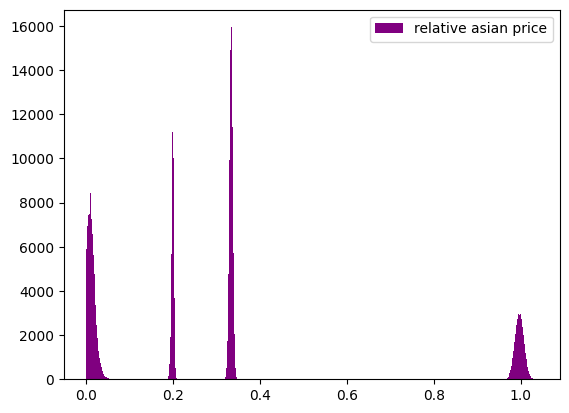

count   208269.000000
mean         0.307827
std          0.331439
min          0.000500
25%          0.017247
50%          0.203631
75%          0.335103
max          1.037593
Name: relative_observed, dtype: float64

In [7]:
"""
plot
"""
rels = data[targetname]
rels = rels[rels>0.0005]
plt.figure()
plt.hist(rels,color='purple',label=relative_pricename.replace('_',' '),bins=int(np.sqrt(len(rels))))
plt.legend()
plt.show()
rels.describe()

['spot_price', 'kappa', 'theta', 'rho', 'eta', 'v0', 'risk_free_rate', 'dividend_rate', 'relative_asian_price', 'spot_price']


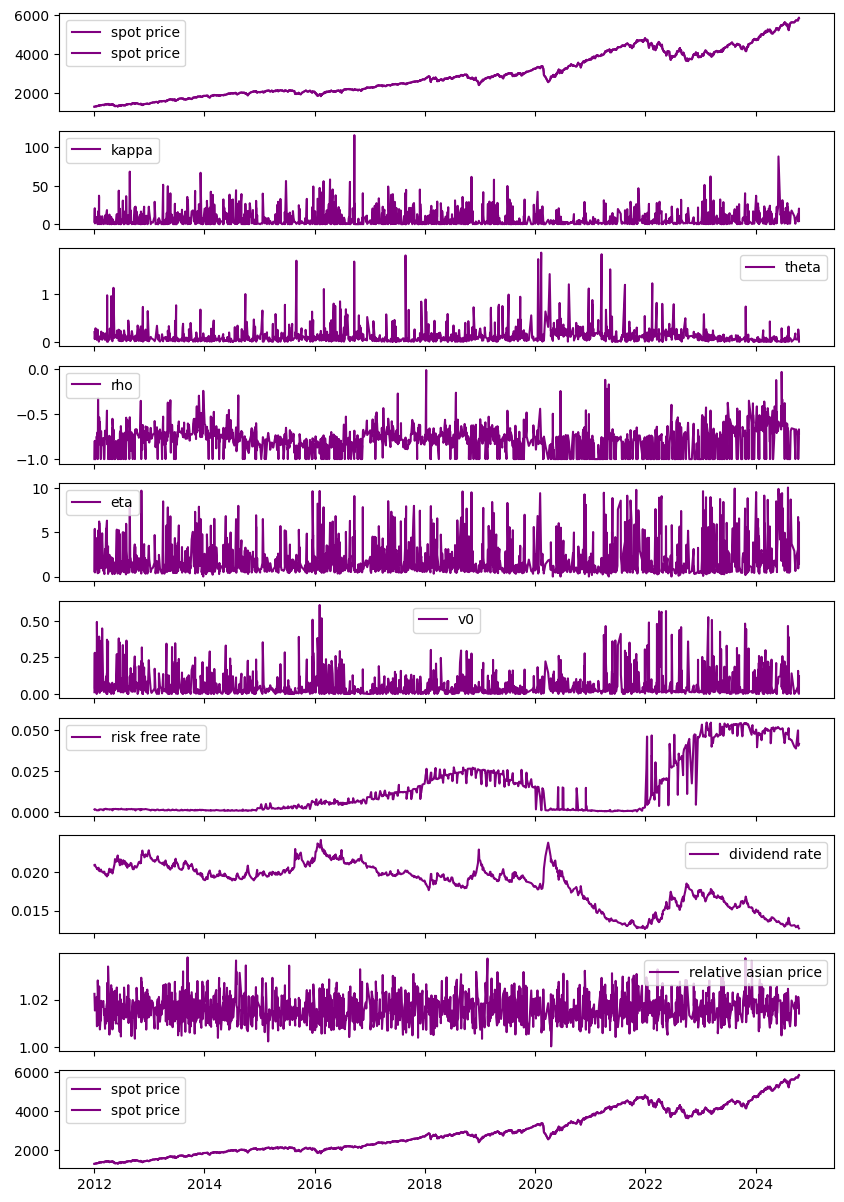

where 'relative_asian_price' is the maximum market observed relative asian option price


count   338940.000000
mean         0.189156
std          0.299911
min          0.000000
25%          0.000000
50%          0.012626
75%          0.330249
max          1.037593
Name: relative_asian_price, dtype: float64

In [8]:
from plotters import PlotCols
col_names = ['spot_price','kappa','theta','rho','eta','v0','risk_free_rate','dividend_rate',relative_pricename,'spot_price']
index = 'calculation_date'
plot_data = data[col_names+[index]].copy().sort_values(by=relative_pricename).drop_duplicates(subset=index,keep='last').sort_values(by=index).reset_index(drop=True)
data_cols = [index] + col_names
PlotCols(
    plot_data,
    col_names=col_names,
    index=index,
    figsize=(10,15)
)
print(f"where '{relative_pricename}' is the maximum market observed relative {pricename[:pricename.find('_',0)]} option price")
pd.Series(plot_data[index])
data[relative_pricename].describe()

# training procedure

## model parameterization and initializaiton

In [9]:
from convsklearn import convsklearn
trainer = convsklearn()
trainer.target_name = relative_pricename
trainer.excluded_features = trainer.excluded_features + ['spot_price','strike_price','barrier','rebate',relative_pricename,'relative_observed']
trainer.__dict__

{'seed': 1312,
 'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'relative_asian_price',
 'excluded_features': ['barrier_price',
  'asian_price',
  'observed_price',
  'outin',
  'updown',
  'n_fixings',
  'spot_price',
  'strike_price',
  'barrier',
  'rebate',
  'relative_asian_price',
  'relative_observed'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'model_fit': None,
 'dnn_runtime': 0,
 'numerical_scaler': StandardScaler()}

In [10]:
trainer.load_data(data)
print('features:')
for f in trainer.feature_set:
    print(f"   {f}")
print(f"\ntarget:\n   {trainer.target_name}",trainer.n_features)
print(trainer.dnn_params)

features:
   days_to_maturity
   fixing_frequency
   past_fixings
   risk_free_rate
   dividend_rate
   kappa
   theta
   rho
   eta
   v0
   relative_spot
   averaging_type
   w

target:
   relative_asian_price 13
{'alpha': 0.01, 'hidden_layer_sizes': (13, 13), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'solver': 'sgd', 'early_stopping': False, 'max_iter': 500, 'warm_start': True, 'tol': 0.0001, 'random_state': 1312}


In [11]:
dates = data['date'].drop_duplicates()

## prepocessing

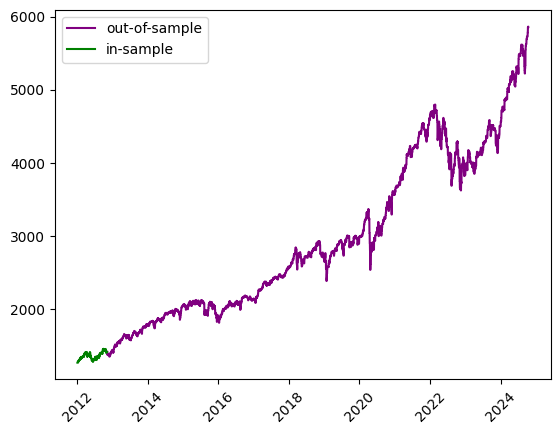

In [12]:
development_dates = dates[:100]#len(dates)//3]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

## training

In [13]:
trainer.run_dnn()


training on 23580 samples...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
random_state: 1312
cpu: 3.5039987564086914


In [14]:
print('instance variables:')

for key, value in trainer.__dict__.items():
    print(f"{key}:\n  {value}\n")

instance variables:
seed:
  1312

raw_data:
          spot_price  strike_price  days_to_maturity  n_fixings  fixing_frequency  past_fixings averaging_type  ...      eta       v0       date asian_price  relative_spot  relative_asian_price  relative_observed
0      1274.000000    637.000000                 7   1.000000                 7             0      geometric  ... 0.601996 0.012430 2012-01-03  636.645019       2.000000              1.001100           1.001100
1      1274.000000    637.000000                 7   1.000000                 7             0      geometric  ... 0.601996 0.012430 2012-01-03    0.000000       2.000000              0.000000           0.000000
2      1274.000000    637.000000                 7   1.000000                 7             0     arithmetic  ... 0.601996 0.012430 2012-01-03  636.682271       2.000000              1.014481           1.014481
3      1274.000000    637.000000                 7   1.000000                 7             0     arithmetic  

## testing

In [15]:
train_test = trainer.test_prediction_accuracy()


in sample:
     RMSE: 0.004642732115114155
     MAE: 0.002831425731926119

out of sample:
     RMSE: 1.2174200290897115
     MAE: 0.7113102404817716


In [16]:
oserr = trainer.test_data['outofsample_error']
iserr = trainer.train_data['insample_error']

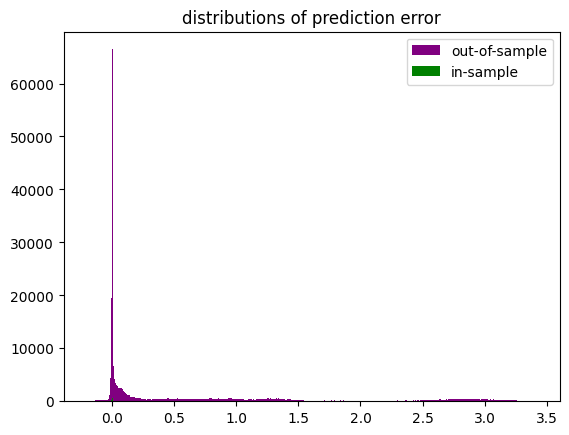

In [17]:
plt.figure()
plt.hist(oserr,color='purple',label='out-of-sample',bins=int(np.sqrt(len(oserr))))
plt.hist(iserr,color='green',label='in-sample',bins=int(np.sqrt(len(iserr))))
plt.legend()
plt.title('distributions of prediction error')
plt.show()

## saving

In [18]:

train_end_tag = ms.timetag()
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_end = time.time()
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")
print(train_end_tag)

execute the command 'save_model()' to save the following model: 2024-11-09 112825652640 cboe spx relative asian

cpu: 8.742932558059692
2024-11-09 112825652640
